## **COVID detection from X-Ray**
Adaptation from https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/

Under tutelage of Dimas Apeco Putra and Gusti Triandi Winata

In [1]:
GIT_PATH = "https://github.com/sanggusti/bangkit_assessment_1.git"
!git clone "{GIT_PATH}"
%cd ./bangkit_assessment_1
%ls
%pwd

fatal: destination path 'bangkit_assessment_1' already exists and is not an empty directory.
/content/bangkit_assessment_1
arief_notebook.ipynb  dataset/              gusti_notebook.ipynb  README.md
covid19.model         dimas_notebook.ipynb  plot.png


'/content/bangkit_assessment_1'

# **Import necessary package**



In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

# **Declare argument variables**

In [0]:
args = {'dataset': 'dataset',
        'plot': 'plot.png',
        'model': 'covid19.model'}

# **Initializing hyperparameter**

In [0]:
learning_rate = 0.001
epochs = 25
batch = 8

# **Initialize the list of data from list of image in dataset**

In [6]:
print("[INFO] This might take a sec ...")
imagePaths = list(paths.list_images(args["dataset"]))
print(imagePaths)
data = []
labels = []

[INFO] This might take a sec ...
['dataset/normal/person1_bacteria_2.jpeg', 'dataset/normal/person939_bacteria_2864.jpeg', 'dataset/normal/person925_virus_1582.jpeg', 'dataset/normal/person1935_bacteria_4849.jpeg', 'dataset/normal/person1290_virus_2215.jpeg', 'dataset/normal/NORMAL2-IM-0315-0001.jpeg', 'dataset/normal/person1558_bacteria_4066.jpeg', 'dataset/normal/person1599_virus_2776.jpeg', 'dataset/normal/person339_bacteria_1574.jpeg', 'dataset/normal/IM-0466-0001.jpeg', 'dataset/normal/person651_bacteria_2543.jpeg', 'dataset/normal/NORMAL2-IM-0696-0001.jpeg', 'dataset/normal/person989_virus_1667.jpeg', 'dataset/normal/NORMAL2-IM-0869-0001.jpeg', 'dataset/normal/person1830_bacteria_4693.jpeg', 'dataset/normal/person259_bacteria_1220.jpeg', 'dataset/normal/person378_virus_761.jpeg', 'dataset/normal/person934_virus_1595.jpeg', 'dataset/normal/person525_bacteria_2216.jpeg', 'dataset/normal/person612_bacteria_2478.jpeg', 'dataset/normal/person438_bacteria_1893.jpeg', 'dataset/normal/pe

# **Looping over image path**

In [0]:
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# **Convert data and label to NumPy array while scaling the pixel intensities to range 0 to 255**

In [0]:
data = np.array(data) / 255.0
labels = np.array(labels)

# **One hot encoding on the label**

In [0]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# **Allocate 80% of data into training and 20% for testing**

In [0]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# **Initialize training data augmentation object**

In [0]:
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

# **Load VGG16 Network**

In [0]:
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# **Construct head of the model**

In [0]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# **Place the head into top of base model**

In [0]:
model = Model(inputs=baseModel.input, outputs=headModel)

# **Loop over all layers in the base model and freeze them so they will not be updated during the first training process**

In [0]:
for layer in baseModel.layers:
	layer.trainable = False

# **Compile our model**

In [16]:
print("[INFO] compiling...")
opt = Adam(lr=learning_rate, decay=learning_rate / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling...


# **Train the head of network**

In [18]:
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=batch),
	steps_per_epoch=len(trainX) // batch,
	validation_data=(testX, testY),
	validation_steps=len(testX) // batch,
	epochs=epochs)

[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
5/5 [==============================] - 21s 4s/step - loss: 0.7677 - accuracy: 0.5750 - val_loss: 0.7120 - val_accuracy: 0.5000
Epoch 2/25
5/5 [==============================] - 21s 4s/step - loss: 0.7656 - accuracy: 0.5250 - val_loss: 0.7049 - val_accuracy: 0.5000
Epoch 3/25
5/5 [==============================] - 21s 4s/step - loss: 0.7461 - accuracy: 0.6000 - val_loss: 0.6672 - val_accuracy: 0.5000
Epoch 4/25
5/5 [==============================] - 21s 4s/step - loss: 0.7402 - accuracy: 0.5750 - val_loss: 0.6211 - val_accuracy: 1.0000
Epoch 5/25
5/5 [==============================] - 21s 4s/step - loss: 0.7253 - accuracy: 0.4750 - val_loss: 0.5994 - val_accuracy: 0.8000
Epoch 6/25
5/5 [==============================] - 21s 4s/step - loss: 0.6659 - accuracy: 0.6500 - val_loss: 0.5768 - val_accuracy: 0.9000
Epoch 7/25
5/5 [==============================] - 21s 4s/step - loss: 0.

# **Make predictions on the testing set**

In [19]:
print("[INFO] evaluating...")
predIdxs = model.predict(testX, batch_size=batch)

[INFO] evaluating...


# **For each image in the testing set we need to find the index of the label with corresponding largest predicted probability**

In [0]:
predIdxs = np.argmax(predIdxs, axis=1)

# **Show classification report**

In [21]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       0.83      1.00      0.91         5
      normal       1.00      0.80      0.89         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



# **Compute the confusion matrix and and use it to derive the raw accuracy, sensitivity, and specificity**

In [0]:
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# **Show the confusion matrix, accuracy, sensitivity, and specificit**

In [23]:
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[5 0]
 [1 4]]
acc: 0.9000
sensitivity: 1.0000
specificity: 0.8000


# **Plot the training loss and accuracy**

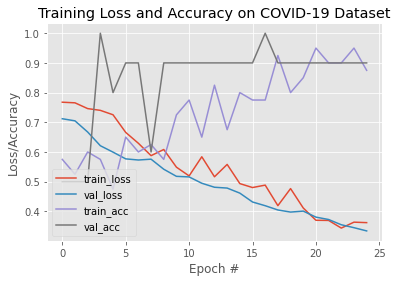

In [25]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])

# **Serialize the model to disk**

In [26]:
print("[INFO] saving COVID-19 detector model...")
model.save(args["model"], save_format="h5")

[INFO] saving COVID-19 detector model...
